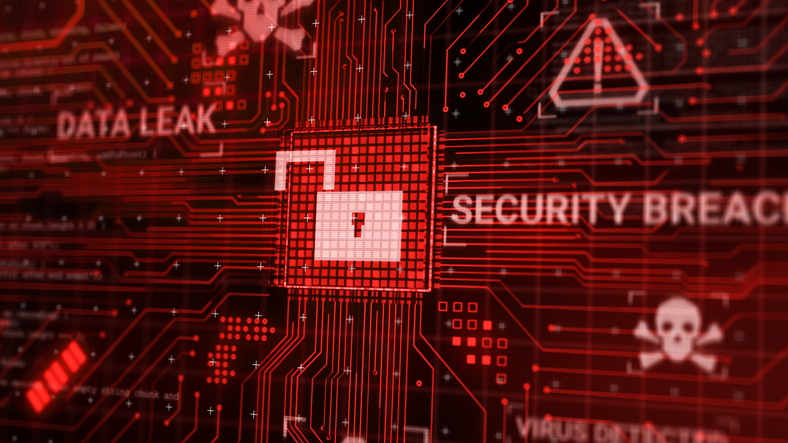

Cyber threats are a growing concern for organizations worldwide. These threats take many forms, including malware, phishing, and denial-of-service (DOS) attacks, compromising sensitive information and disrupting operations. The increasing sophistication and frequency of these attacks make it imperative for organizations to adopt advanced security measures. Traditional threat detection methods often fall short due to their inability to adapt to new and evolving threats. This is where deep learning models come into play.

Deep learning models can analyze vast amounts of data and identify patterns that may not be immediately obvious to human analysts. By leveraging these models, organizations can proactively detect and mitigate cyber threats, safeguarding their sensitive information and ensuring operational continuity.

As a cybersecurity analyst, you identify and mitigate these threats. In this project, you will design and implement a deep learning model to detect cyber threats. The BETH dataset simulates real-world logs, providing a rich source of information for training and testing your model. The data has already undergone preprocessing, and we have a target label, `sus_label`, indicating whether an event is malicious (1) or benign (0).

By successfully developing this model, you will contribute to enhancing cybersecurity measures and protecting organizations from potentially devastating cyber attacks.


### The Data

| Column     | Description              |
|------------|--------------------------|
|`processId`|The unique identifier for the process that generated the event - int64 |
|`threadId`|ID for the thread spawning the log - int64|
|`parentProcessId`|Label for the process spawning this log - int64|
|`userId`|ID of user spawning the log|Numerical - int64|
|`mountNamespace`|Mounting restrictions the process log works within - int64|
|`argsNum`|Number of arguments passed to the event - int64|
|`returnValue`|Value returned from the event log (usually 0) - int64|
|`sus_label`|Binary label as suspicous event (1 is suspicious, 0 is not) - int64|

More information on the dataset: [BETH dataset](accreditation.md)

#### How to approach the project
1. Loading and Scaling Data
2. Define the Neural Network Model
3. Train and evaulate the model

In [50]:
# Make sure to run this cell to use torchmetrics. If you cannot use pip install to install the torchmetrics, you can use sklearn.
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [51]:
# Import required libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as functional
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchmetrics import Accuracy
from sklearn.metrics import accuracy_score  

### 1. Loading and Scaling Data
Start by separating features and labels, scaling the features, and converting data to PyTorch tensors.

In [52]:
def load_and_preview_data(train_path, test_path, val_path):
    # Load preprocessed data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    val_df = pd.read_csv(val_path)
    
    # View the first 5 rows of each dataset
    print("Training Set:")
    display(train_df.head())
    
    print("Test Set:")
    display(test_df.head())
    
    print("Validation Set:")
    display(val_df.head())
    
    return train_df, test_df, val_df

# Example usage
train_df, test_df, val_df = load_and_preview_data('labelled_train.csv', 'labelled_test.csv', 'labelled_validation.csv')

Training Set:


,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,7337,1,100,4026532231,5,0,1
1,381,7337,1,100,4026532231,1,0,1
2,381,7337,1,100,4026532231,0,0,1
3,7347,7347,7341,0,4026531840,2,-2,1
4,7347,7347,7341,0,4026531840,4,0,1


Test Set:


,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,382,382,1,101,4026532232,3,15,0
1,379,379,1,100,4026532231,3,15,0
2,1,1,0,0,4026531840,4,0,0
3,1,1,0,0,4026531840,4,17,0
4,1,1,0,0,4026531840,2,0,0


Validation Set:


,processId,threadId,parentProcessId,userId,mountNamespace,argsNum,returnValue,sus_label
0,381,381,1,101,4026532232,3,15,0
1,378,378,1,100,4026532231,3,15,0
2,1,1,0,0,4026531840,4,0,0
3,1,1,0,0,4026531840,4,12,0
4,1,1,0,0,4026531840,2,0,0


In [54]:
def load_and_inspect_data(train_path, test_path, val_path):
    # Load preprocessed data
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    val_df = pd.read_csv(val_path)
    
    # Function to display info and check for missing values
    def inspect_data(df, name):
        print(f"{name} Set Info:")
        display(df.info())
        print(f"{name} Set Missing Values:")
        display(df.isna().sum())
    
    # Inspect each dataset
    inspect_data(train_df, "Training")
    inspect_data(test_df, "Test")
    inspect_data(val_df, "Validation")
    
    return train_df, test_df, val_df

# Example usage
train_df, test_df, val_df = load_and_inspect_data('labelled_train.csv', 'labelled_test.csv', 'labelled_validation.csv')

Training Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763144 entries, 0 to 763143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   processId        763144 non-null  int64
 1   threadId         763144 non-null  int64
 2   parentProcessId  763144 non-null  int64
 3   userId           763144 non-null  int64
 4   mountNamespace   763144 non-null  int64
 5   argsNum          763144 non-null  int64
 6   returnValue      763144 non-null  int64
 7   sus_label        763144 non-null  int64
dtypes: int64(8)
memory usage: 46.6 MB


None

Training Set Missing Values:


processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
argsNum            0
returnValue        0
sus_label          0
dtype: int64

Test Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188967 entries, 0 to 188966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   processId        188967 non-null  int64
 1   threadId         188967 non-null  int64
 2   parentProcessId  188967 non-null  int64
 3   userId           188967 non-null  int64
 4   mountNamespace   188967 non-null  int64
 5   argsNum          188967 non-null  int64
 6   returnValue      188967 non-null  int64
 7   sus_label        188967 non-null  int64
dtypes: int64(8)
memory usage: 11.5 MB


None

Test Set Missing Values:


processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
argsNum            0
returnValue        0
sus_label          0
dtype: int64

Validation Set Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188967 entries, 0 to 188966
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   processId        188967 non-null  int64
 1   threadId         188967 non-null  int64
 2   parentProcessId  188967 non-null  int64
 3   userId           188967 non-null  int64
 4   mountNamespace   188967 non-null  int64
 5   argsNum          188967 non-null  int64
 6   returnValue      188967 non-null  int64
 7   sus_label        188967 non-null  int64
dtypes: int64(8)
memory usage: 11.5 MB


None

Validation Set Missing Values:


processId          0
threadId           0
parentProcessId    0
userId             0
mountNamespace     0
argsNum            0
returnValue        0
sus_label          0
dtype: int64

#### Separating Features and Labels
- Drop the `sus_label` column from each DataFrame to separate features and assign the `sus_label` column to the labels

In [55]:
# Separate features and labels for training, testing, and validation sets
X_train = train_df.drop('sus_label', axis=1).values
y_train = train_df['sus_label'].values

X_test = test_df.drop('sus_label', axis=1).values
y_test = test_df['sus_label'].values

X_val = val_df.drop('sus_label', axis=1).values
y_val = val_df['sus_label'].values

#### Scaling Features
- Initialize a `StandardScaler()` from `sklearn.preprocessing` to scale the features
- Fit the scaler on the training data and transform the training data.
Use the fitted scaler to transform the test and validation data

In [56]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)

# Transform the test and validation data using the fitted scaler
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

### 2. Define the Neural Network Model
Define a neural network model using PyTorch's `nn.Sequential()` to create a feed-forward neural network with specified layers and activations.

#### Converting to PyTorch Tensors
- Convert the numpy arrays for features and labels to PyTorch tensors using `torch.tensor()`
- Ensure the features are converted to float32 type and the labels are reshaped to have a dimension of (-1, 1)

In [57]:
# Convert the numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

#### Creating the Model
- Use `nn.Sequential()` to define the model structure
- Include three fully connected layers `nn.Linear()` with appropriate input and output dimensions
- Add ReLU activation functions `nn.ReLU()` between the layers
- Use a Sigmoid activation function `nn.Sigmoid()` at the output layer for binary classification

In [58]:
# The sigmoid is commonly used as the last step in a neural network when performing binary classification.

# Define the model using nn.Sequential
model = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),  # First fully connected layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(128, 64),  # Second fully connected layer
    nn.ReLU(),  # ReLU activation
    nn.Linear(64, 1),  # Third fully connected layer
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

model

Sequential(
  (0): Linear(in_features=7, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=1, bias=True)
  (5): Sigmoid()
)

#### Initializing Loss Function and Optimizer
- Use `nn.CrossEntropyLoss()`
- Initialize the optimizer using `optim.SGD` with a learning rate of `1e-3` and `weight_decay 1e-4`

In [59]:
# Initialize the loss function and optimizer
# The higher the parameter, the less likely the models to overfit
# In PyTorch, weight decay can be added to the optimizer, The weight decay term effectively penalizes large weights and helps prevent overfitting
# Optimizar's weight_decay parameter takes values between 0 and 1 (typically small value , e.g. 1e-3)
# The weight decay term effectively penalizes large weights and helps prevent overfitting
# We can also use weight decay to force the parameters to remain small (to avoid overfitting)

criterion = nn.CrossEntropyLoss() 

optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0.0001
)

### 3. Train and evaulate the model
Implement a training loop to train the neural network model using the training data. Update the model parameters based on the computed loss.

#### Setting Up the Training Loop
- Iterate through the specified number of epochs
- Set the model to training mode using `model.train()`
- Clear the gradients using `optimizer.zero_grad()`
- Perform a forward pass to compute the model outputs
- Compute the loss using the loss function
- Perform a backward pass to compute the gradients
- Update the model parameters using `optimizer.step()`

In [61]:
# Training loop
# Looping through the entire dataset once is called an epoch and we train over multiple epochs, indicated by num_epochs. 

num_epoch = 10
for epoch in range(num_epoch):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear the gradients (set the gradients to zero)
    outputs = model(X_train_tensor)  # Forward pass: compute the model output
    loss = criterion(outputs, y_train_tensor)  # Compute or calculate the loss
    loss.backward()  # Backward pass: compute the gradients
    optimizer.step()  # Update the model parameters

#### Evaluating the Model
- Evaluate the trained model on training, testing, and validation datasets. Calculate and print the accuracy for each dataset.
- Use `torchmetrics.Accuracy()` to calculate the accuracy for training, testing, and validation datasets.

In [62]:
# Model Evaluation
# We first need to use the .eval method of the model to put the model in evaluation mode, because some layers in PyTorch models behave differently at training versus validation stages
# We also add a Python context with torch.no_grad, indicating we will not be performing gradient calculation in this epoch

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for efficiency
    # Predict on training data and round the outputs
    y_predict_train = model(X_train_tensor).round()  
    # Predict on test data and round the outputs
    y_predict_test = model(X_test_tensor).round()  
    # Predict on validation data and round the outputs
    y_predict_val = model(X_val_tensor).round()  

# Calculate accuracy using torchmetrics
accuracy = Accuracy(task="binary")
print(accuracy, '\n')   

train_accuracy = accuracy(y_predict_train, y_train_tensor)
print(train_accuracy)
test_accuracy = accuracy(y_predict_test, y_test_tensor)
print(test_accuracy)
val_accuracy = accuracy(y_predict_val, y_val_tensor)
print(val_accuracy)

BinaryAccuracy() 

tensor(0.9944)
tensor(0.0922)
tensor(0.9895)


In [63]:
# convert to int or float
train_accuracy = train_accuracy.item()
print(train_accuracy)
test_accuracy = test_accuracy.item()
print(test_accuracy)
val_accuracy = val_accuracy.item()
print(val_accuracy)

print("Training accuracy: {0}".format(train_accuracy))
print("Validation accuracy: {0}".format(val_accuracy))
print("Testing accuracy: {0}".format(test_accuracy))

0.9944244027137756
0.09218540787696838
0.9895378351211548
Training accuracy: 0.9944244027137756
Validation accuracy: 0.9895378351211548
Testing accuracy: 0.09218540787696838
